<a href="https://colab.research.google.com/github/francesco-vaccari/ProjectDL/blob/fra/Gradcam_with_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Download and global variables

In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
!tar -xf /content/refcocog.tar.gz
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.4 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3zne2o26
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3zne2o26
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=7db63767cc4bfa580f1eb8c145f8e49ef0ea97cf4c21c8296caadde10fb380a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-q_yp7g2k/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100% 13.5G/13.5G [05:36<00:00, 40.0MB/s]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.5/612.5

In [3]:
!pip install opencv-python matplotlib
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-m6jwn562
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-m6jwn562
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=137c0c1d1014b2273b7ce2bc9fc3b731c9c6d78a025ef4dc5a8349c9ea0bf398
  Stored in directory: /tmp/pip-ephem-wheel-cache-y0o457rx/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-07-04 15:30:09--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.8.51, 13.35.8.19, 13.35.8.29, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.8.51|:443

In [4]:
# General Variables
REFCOCOG_PATH = "refcocog"

### Dataset

In [5]:
import json
import clip
import torch
import pandas
import numpy as np

from torch.utils.data import Dataset, DataLoader
from typing import Sequence, Union

from PIL import Image, ImageDraw



class RefcocogDataset(Dataset):
    def __init__(self, base_path, split=None, transform=None, tokenization=None):
        annotation_path = base_path + "/annotations/"

        self.IMAGES_PATH = base_path + "/images/"
        self.transform = transform
        self.tokenization = tokenization

        tmp_annotations = pandas.read_pickle(annotation_path + "refs(umd).p")
        tmp_instances = json.load(open(annotation_path + "instances.json", "r"))

        annotations_dt = pandas.DataFrame.from_records(tmp_annotations) \
            .filter(items=["image_id", "split", "sentences", "ann_id"])

        instances_dt = pandas.DataFrame.from_records(tmp_instances['annotations'])

        self.annotations = annotations_dt \
            .merge(instances_dt[["id", "bbox", "area"]], left_on="ann_id", right_on="id") \
            .drop(columns="id")

        if split is not None:
            self.annotations = self.__get_annotations_by_split(split.lower())

    def getImage(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]
        image = self.__getimage(item.image_id)

        return image

    def getSentences(self, sample):
        id = sample['idx'][0].item()
        item = self.annotations.iloc[id]

        return self.__extract_sentences(item.sentences)

    def showImage(self, train_features, train_bbox):
        img = self.getImage(train_features)
        img1 = ImageDraw.Draw(img)
        img1.rectangle([(train_bbox[0].item(), train_bbox[1].item()), (train_bbox[0].item()+train_bbox[2].item(), train_bbox[1].item()+train_bbox[3].item())], outline ="red")
        img.show()

    def __get_annotations_by_split(self, split):
        return self.annotations[self.annotations.split == split].reset_index()

    def __getimage(self, id):
        return Image.open(self.IMAGES_PATH + "COCO_train2014_" + str(id).zfill(12) + ".jpg")

    def __extract_sentences(self, sentences):
        return [f"a photo of {s['sent']}" for s in sentences]

    def __tokenize_sents(self, sentences):
        return [self.tokenization(s) for s in sentences]

    def __len__(self):
        return self.annotations.shape[0]

    def __getitem__(self, idx):
        item = self.annotations.iloc[idx]
        image = self.__getimage(item.image_id)
        sentences = self.__extract_sentences(item.sentences)

        if self.transform:
            image = self.transform(image)

        if self.tokenization:
            sentences = self.__tokenize_sents(sentences)

        sample = {'idx': idx, 'image': image, 'sentences': sentences}

        return sample, item.bbox

In [6]:
_, preprocess = clip.load("RN50")

train_dataset = RefcocogDataset(REFCOCOG_PATH, split="train", transform=preprocess, tokenization=clip.tokenize)
val_dataset = RefcocogDataset(REFCOCOG_PATH, split="val", transform=preprocess, tokenization=clip.tokenize)
test_dataset = RefcocogDataset(REFCOCOG_PATH, split="test", transform=preprocess, tokenization=clip.tokenize)

train_dataloader = DataLoader(train_dataset, shuffle=False)
val_dataloader = DataLoader(val_dataset, shuffle=False)
test_dataloader = DataLoader(test_dataset, shuffle=False)

100%|████████████████████████████████████████| 244M/244M [00:01<00:00, 157MiB/s]


### How to use Dataset

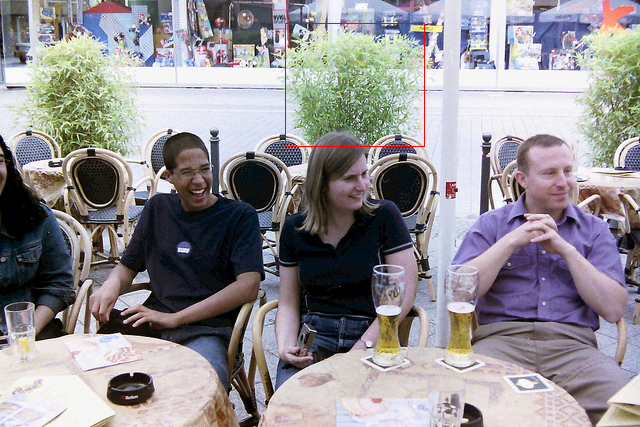

['a photo of two woman one in black eatting and the other has a white shirt at the desk', 'a photo of woman in white shirt looking down at laptop computer']
42226
2573
5023


In [7]:
train_features, train_bbox = next(iter(val_dataloader))
val_dataset.showImage(train_features, train_bbox)
print(train_dataset.getSentences(train_features))
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

for data_features, data_bbox in val_dataloader:
    images = val_dataset.getImage(data_features)
    index = data_features['idx']
    image = data_features['image']
    sentences = data_features['sentences']
    break

### GRADCAM

In [8]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import clip
from PIL import Image
from scipy.ndimage import gaussian_filter
from torch import nn


def normalize(x: np.ndarray) -> np.ndarray:
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def getCmap(img, attn_map, blur=True):
    if blur:
        attn_map = gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    return attn_map_c

def viz_attn(img, attn_map, blur=True):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()

def load_image(image, resize=None):
    image = image.convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    return np.asarray(image).astype(np.float32) / 255.


class Hook:
    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)

    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()

    @property
    def activation(self) -> torch.Tensor:
        return self.data

    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad


def gradCAM(model: nn.Module, input: torch.Tensor, target: torch.Tensor, layer: nn.Module) -> torch.Tensor:
    if input.grad is not None:
        input.grad.data.zero_()

    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)

    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()

        alpha = grad.mean(dim=(2, 3), keepdim=True)
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        gradcam = torch.clamp(gradcam, min=0)

    gradcam = F.interpolate(gradcam, input.shape[2:], mode='bicubic', align_corners=False)

    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])

    return gradcam


class FeatureCouple:
    def __init__(self, index, image_feature, sentence_feature, norm_image_feature, norm_sentence_feature):
        self.index = index
        self.image_feature = image_feature
        self.sentence_feature = sentence_feature
        self.similarity = norm_image_feature * norm_sentence_feature


def getSalientEncodedFeatures(preprocessed_image, encoded_text, model):
    with torch.no_grad():
        encoded_image = model.encode_image(preprocessed_image).float()
        norm_encoded_image = encoded_image / encoded_image.norm(dim=-1, keepdim=True)
        norm_encoded_text = encoded_text / encoded_text.norm(dim=-1, keepdim=True)
        original_sim = norm_encoded_text.cpu().numpy() @ norm_encoded_image.cpu().numpy().T


        features = []
        for i in range(1024):
            features.append(FeatureCouple(i, encoded_image[0][i].item(), encoded_text[0][i].item(), norm_encoded_image[0][i].item(), norm_encoded_text[0][i].item()))
        features.sort(key=lambda x: x.similarity, reverse=True)

        reconstruct_indexes = set()
        reconstruct_sim = 0
        for elem in features:
            if reconstruct_sim / original_sim < 0.95:
                reconstruct_sim += elem.similarity
                reconstruct_indexes.add(elem.index)

        for index in range(1024):
            if index not in reconstruct_indexes:
                encoded_text[0][index] = 0
                encoded_image[0][index] = 0
                norm_encoded_image[0][index] = 0
                norm_encoded_text[0][index] = 0

    return encoded_image, encoded_text
    return norm_encoded_image, norm_encoded_text

### Models

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
modelCLIP, preprocessCLIP = clip.load("RN50", device=device)

In [10]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device=device)

sam = SamPredictor(sam)

### Testing

In [24]:
from PIL import Image
import math

def get_crops(image, n, overlap=True):
    width, height = image.size

    w_offset = width/(n)
    h_offset = height/(n)

    crops = []
    for s in range(1, n):
        x = 0
        for i in range(n-s+1):
            y = 0
            for j in range(n-s+1):
                crops.append((round(x), round(y), round(x+s*w_offset), round(y+s*h_offset)))
                y += h_offset
            x += w_offset


    crops_overlap = []
    if overlap:
        for s in range(1, n):
            x = w_offset/2
            for i in range(n-s):
                y = h_offset/2
                for j in range(n-s):
                    crops.append((round(x), round(y), round(x+s*w_offset), round(y+s*h_offset)))
                    y += h_offset
                x += w_offset

    coordinates = crops + crops_overlap

    crops = []
    for x, y, x_end, y_end in coordinates:
        crops.append(image.crop((x, y, x_end, y_end)))

    crops.append(image)
    coordinates.append((0, 0, width, height))

    return crops, coordinates

def compute_similarity(image, sentences, modelCLIP, preprocessCLIP):
    similarities = []
    for sent in sentences:
        with torch.no_grad():
            image_features = modelCLIP.encode_image(torch.unsqueeze(preprocessCLIP(image).to(device), dim=0)).float().to(device)
            text_features = modelCLIP.encode_text(sent[0].to(device)).float().to(device)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarities.append(text_features.cpu().numpy() @ image_features.cpu().numpy().T)
    return sum(similarities)/len(similarities)

def get_best_crop(crops, sentences_preprocessed, modelCLIP, preprocessCLIP):
    best_sim = 0.0
    best_crop = crops[0]
    best_index = 0
    for i, crop in enumerate(crops):
        sim = compute_similarity(crop, sentences_preprocessed, modelCLIP, preprocessCLIP)
        if sim > best_sim:
            best_sim = sim
            best_crop = crop
            best_index = i

    return best_crop, best_sim, best_index

def combine_and_get_average_point(color_maps):
    combined_cmap = np.zeros((224, 224, 3))
    for cmap in color_maps:
        combined_cmap += cmap
    combined_cmap /= len(color_maps)

    filter_cmap = np.ones((224, 224, 1))

    for x, row in enumerate(combined_cmap):
        for y, pixel in enumerate(row):
            if pixel[0] > 0.4 and pixel[1] < 0.5 and pixel[2] < 0.5:
                gray = (pixel[0] + pixel[1] + pixel[2])/3
                filter_cmap[x][y] = gray

    total_weighted_x = 0
    total_weighted_y = 0
    total_weight = 0
    for y, row in enumerate(filter_cmap):
        for x, pixel in enumerate(row):
            if pixel != 1:
                total_weighted_x += x * pixel
                total_weighted_y += y * pixel
                total_weight += pixel

    if total_weight == 0:
        return np.array([112]), np.array([112])

    average_x = total_weighted_x / total_weight
    average_y = total_weighted_y / total_weight

    return average_x, average_y

def remap_coordinates_to_original_image(x, y, crop_size, crop_coordinates):
        crop_w, crop_h = crop_size
        x_start, y_start, _, _ = crop_coordinates

        remap_x = x_start + (crop_w/224)*x
        remap_y = y_start + (crop_h/224)*y

        return remap_x, remap_y

def extract_bbox_from_masks(masks, scores):
    mask = masks[np.argmax(scores)]

    trues = np.argwhere(mask)

    x_min = np.min(trues[:, 0])
    x_max = np.max(trues[:, 0])
    y_min = np.min(trues[:, 1])
    y_max = np.max(trues[:, 1])

    return y_min, x_min, y_max, x_max

def computeIntersection(fx1, fy1, fx2, fy2, sx1, sy1, sx2, sy2):
    dx = min(fx2, sx2) - max(fx1, sx1)
    dy = min(fy2, sy2) - max(fy1, sy1)
    if (dx>=0) and (dy>=0):
        area = dx*dy
    else:
        area = 0
    return area

def computeAccuracy(pred, label):
    intersection = computeIntersection(pred[0], pred[1], pred[2], pred[3],
                                       label[0].item(), label[1].item(), label[0].item()+label[2].item(), label[1].item()+label[3].item())
    area1 = (pred[2]-pred[0])*(pred[3]-pred[1])
    area2 = label[2].item()*label[3].item()
    union = area1 + area2 - intersection
    return intersection / union

In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [38]:
i = 0
tot_accuracy = 0
n = 0
for data_features, data_bbox in val_dataloader:
    i += 1
    image_preprocessed = data_features['image']
    sentences_preprocessed = data_features['sentences']
    image_original = val_dataset.getImage(data_features)
    sentences_original = val_dataset.getSentences(data_features)
    bbox = (data_bbox[0].item(), data_bbox[1].item(), data_bbox[2].item(), data_bbox[3].item())


    crops, crops_coordinates = get_crops(image_original, 3, overlap=True)

    crop, sim, index = get_best_crop(crops, sentences_preprocessed, modelCLIP, preprocessCLIP)

    preprocessed_crop = preprocessCLIP(crop).unsqueeze(0).to(device)

    color_maps = []

    for sent in sentences_original:
        encoded_text = modelCLIP.encode_text(clip.tokenize([sent]).to(device)).float()

        attn_map = gradCAM(modelCLIP.visual, preprocessed_crop, encoded_text, getattr(modelCLIP.visual, "layer4"))
        attn_map = attn_map.squeeze().detach().cpu().numpy()

        cmap = getCmap(load_image(crop, modelCLIP.visual.input_resolution), attn_map, blur=False)
        color_maps.append(cmap)

    x, y = combine_and_get_average_point(color_maps)

    x, y = remap_coordinates_to_original_image(x, y, crop.size, crops_coordinates[index])

    image = np.array(image_original)
    if image.ndim == 2: # this is needed because if an image is grayscale it creates an array without the 3 rgb channels
        image_rgb = np.empty((image.shape[0], image.shape[1], 3), dtype=np.uint8)
        image_rgb[:, :, 0] = image
        image_rgb[:, :, 1] = image
        image_rgb[:, :, 2] = image
        image = image_rgb

    sam.set_image(image)


    masks, scores, _ = sam.predict(
        point_coords=np.array([[math.floor(x[0]), math.floor(y[0])]]),
        point_labels=np.array([1]),
        multimask_output=True,
    )


    # for i, (mask, score) in enumerate(zip(masks, scores)):
    #     plt.figure(figsize=(10,10))
    #     plt.imshow(image_original)
    #     show_mask(mask, plt.gca())
    #     show_points(np.array([[math.floor(x[0]), math.floor(y[0])]]), np.array([1]), plt.gca())
    #     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    #     plt.axis('off')
    #     plt.show()

    ###########################################


    x_min, y_min, x_max, y_max = extract_bbox_from_masks(masks, scores)
    pred_bbox = (x_min, y_min, x_max, y_max)

    accuracy = computeAccuracy(pred_bbox, data_bbox)

    print(f"Sample {i}/{len(val_dataloader)}\taccuracy {accuracy}")
    tot_accuracy += accuracy
    n += 1

    if(i%100 == 0):
        print(f"Partial accuracy {tot_accuracy/n}")

print(f"Accuracy {tot_accuracy/n}")

Sample 1/2573	accuracy 0.0
Sample 2/2573	accuracy 0.00031973704462479437
Sample 3/2573	accuracy 0.9282568572175399


KeyboardInterrupt: ignored